In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
nfft = 2048
integrate = 585
fs = 240e3
tstart = np.datetime64('2020-11-29T09:20:22.248176')

In [3]:
cvector = [np.array([1,0,0]), np.array([0,1,0]), np.array([0,0,1]), np.array([0.5,0.5,0.0])]
vmin = -2
vrange = 15

img = None

for channel in range(4):
    x = np.array([
        np.fromfile(f'/home/destevez/CE5/multichannel/CE5_2020-11-29T09:20:13.661224_0{pol}_{channel}.spectrum',
                    dtype = 'float32').reshape((-1,nfft))
        for pol in ('x', 'y')])
    gain_offset = np.average((np.median(x[0], axis = 1)/np.median(x[1], axis = 1)))
    x[1] *= gain_offset
    gain_avg = np.average(np.median(x, axis = 2))
    x[:] /= gain_avg
    x = np.average(x, axis = 0)
    #shift for clarity
    x[:] = np.roll(x, int(64*(channel-1.5)), axis = 1)
    # correct for 30kHz shifts
    x[1951:] = np.roll(x[1951:,], -256, axis = 1)
    x[2214:] = np.roll(x[2214:,], -256, axis = 1)

    if img is None:
        img = np.zeros((nfft, x.shape[0], 3))

    img += np.clip((10*np.log10(x[:,::-1].T)-vmin)/vrange, 0, 1)[...,np.newaxis]*cvector[channel]

img *= 0.25/np.average(np.array(cvector), axis = 0)

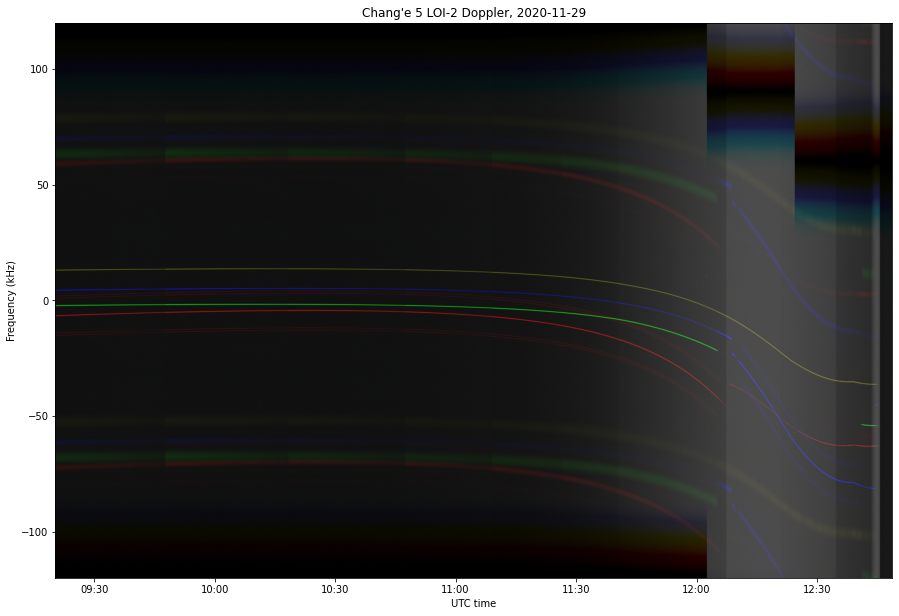

In [4]:
plt.figure(figsize = (15,15), facecolor = 'w')
tend = tstart + int(np.round(1e9*integrate*nfft/fs*img.shape[1]))*np.timedelta64(1,'ns')
plt.imshow(img, extent = (mdates.date2num(tstart),mdates.date2num(tend), -120, 120),
          aspect = 4e-4)
plt.gca().set_xlim((tstart, tend))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylabel('Frequency (kHz)')
plt.xlabel('UTC time')
plt.title('Chang\'e 5 LOI-2 Doppler, 2020-11-29');